In [1]:
import numpy as np
import pandas as pd
import re
import operator
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition

from gensim.models import Word2Vec, phrases, Phrases
from gensim.parsing.preprocessing import STOPWORDS as stop_words

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient

import matplotlib as mpl
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm')

import os
from azure.storage.blob import BlobServiceClient
import io

# For PDF extraction
import PyPDF2

In [2]:
from dotenv import load_dotenv

In [3]:
# Load environment variables or set directly
load_dotenv(dotenv_path=".azure/KapGPT-dev/.env")
account_url = f"https://stqrzha7zt4ecfq.blob.core.windows.net"

container_name = "kapcoach-docs"
print(container_name)

kapcoach-docs


In [4]:

credential = DefaultAzureCredential()
blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)
container_client = blob_service_client.get_container_client(container_name)

In [5]:
#Create List of text corpi
corpus = []

for blob in container_client.list_blobs():
    if blob.name.endswith('.txt') or blob.name.endswith('.pdf'):
        blob_client = container_client.get_blob_client(blob)
        blob_data = blob_client.download_blob().readall()
        if blob.name.endswith('.txt'):
            text = blob_data.decode('utf-8', errors='ignore')
            corpus.append(text)
        elif blob.name.endswith('.pdf'):
            with io.BytesIO(blob_data) as pdf_file:
                reader = PyPDF2.PdfReader(pdf_file)
                pdf_text = ""
                for page in reader.pages:
                    pdf_text += page.extract_text() or ""
                corpus.append(pdf_text)

#input_txt = "\n".join(corpus)
df_corpus = pd.DataFrame({'input_text': corpus})


In [6]:
#### Clean & Preprocess Text

# Function to clean text
def clean_text(txt):
    # exclude meta data, quotes and newline expressions
    excl_meta = re.sub("\n|\'|\s\d+\s+", ' ', txt.split('Lines:')[-1])
    excl_meta = re.sub('In article\s.*writes:?', '', excl_meta)
    excl_meta = re.sub('(distribution:|nntp-posting-host:)\s*\S*\s?', ' ', excl_meta.lower())
    
    # exclude emails and urls
    excl_email = re.sub('\S*@\S*\s?', ' ', excl_meta)
    excl_url = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', ' ', excl_email) 
    
    # exclude non-characters and trim text
    excl_nonchar = re.sub('[^a-zA-Z\s]', ' ', excl_url)  
    excl_trim = re.sub('\s\s+', ' ', excl_nonchar).strip()

    return(excl_trim)


# Store all documents (cleaned text) within list
documents = df_corpus['input_text'].map(lambda text: clean_text(text)).tolist()

# # Preview document (cleaned but without text-processing)
# documents[10]

# Lemmatise reviews using spaCy
documents_lemma = []
for document in documents:
    doc_spacy = nlp(document)
    doc_lemma = ' '.join(token.lemma_ for token in doc_spacy if not token.is_stop and token.is_alpha)
    documents_lemma.append(doc_lemma)


# Nested lists of tokens for each document
tokens = [[token for token in doc.split(' ')] for doc in documents_lemma]
#tokens = [[token for token in doc.split(' ')] for doc in documents]


In [7]:
# Train bigram model
bigram = Phrases(tokens, min_count=3, threshold=10)
bigram_mod = phrases.Phraser(bigram)

# Apply bigram model to corpus
tokens_bigrams = [bigram_mod[doc] for doc in tokens]

# +
# List placeholder for post-processed document text
docs_processed = []

# Reconstruct documents (incl bigrams); exclude stopwords (and short/long tokens)
for doc in tokens_bigrams:
    doc = ' '.join([token for token in doc \
                        if (3 < len(token) < 25) \
                            and token not in stop_words])
    docs_processed.append(doc)

# # Capture all bigrams (for preview only)
# bigram_list = []
# [[bigram_list.append(token) \
#     for token in doc if re.search('_', token)] \
#         for doc in tokens_bigrams]

bigram_set = set()
for doc in tokens_bigrams:
    for token in doc:
        if '_' in token:
            bigram_set.add(token)

# # Preview top 25 bigrams
# for i in sorted(bigram_set)[:25]:
#     print(i)

# len(docs_processed)



In [8]:
docs_processed[0]

'radical_candor radical_candor communication framework develop kim_scott emphasize_importance care_personally challenge_directly design foster open honest constructive_feedback professional setting help build_strong relationship improve team_dynamic let_s explore component radical_candor apply effectively component radical_candor care_personally mean genuinely_care people work employee human_being empathy understanding help build_trust rapport challenge_directly involve provide_clear specific honest_feedback address_issue head sugar coating avoid difficult_conversation goal help grow improve straightforward radical_candor framework radical_candor framework illustrate grid quadrant radical_candor ideal quadrant care_personally challenge_directly feedback kind clear specific ruinous_empathy occur care_personally fail challenge_directly avoid necessary feedback spare_feeling ultimately unhelpful obnoxious_aggression happen challenge_directly care_personally feedback blunt perceive harsh i

In [9]:
# --- Chunk large documents into <=20,000 token chunks ---
chunk_size = 1500
chunked_docs = []

for idx, doc in enumerate(docs_processed):
    tokens = doc.split()
    n_tokens = len(tokens)
    print(n_tokens)
    if n_tokens > chunk_size:
        n_chunks = (n_tokens + chunk_size - 1) // chunk_size  # ceil division
        for i in range(n_chunks):
            chunk = tokens[i*chunk_size:(i+1)*chunk_size]
            chunked_docs.append(' '.join(chunk))
    else:
        chunked_docs.append(doc)

print(f"Original docs: {len(docs_processed)} | After chunking: {len(chunked_docs)}")
# Now use chunked_docs in place of docs_processed for downstream steps

647
5605
428
45827
1576
1450
908
579
445
679
878
2698
1066
684
1343
Original docs: 15 | After chunking: 50


In [10]:
len(chunked_docs)

50

In [11]:
# #### Token weightings
# Create document-term matrix, weighted by tfidf
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=0.8)
tfidf_model = tfidf_vectorizer.fit(chunked_docs)
tfidf_dtm = tfidf_model.transform(chunked_docs)

# Tfidf dimensions
print("%d documents and %d tokens" % (tfidf_dtm.shape[0], tfidf_dtm.shape[1]))

# Function to rank token on weighting
def rank_tokens(dtm_matrix, tokens):
    # sum over matrix columns
    sum_cols = dtm_matrix.sum(axis=0)
    
    # dictionary linking weightings to tokens
    weights = {}
    for col, token in enumerate(tokens):
        weights[token] = sum_cols[0, col]
    
    # sort tokens by weight over all documents
    tokens_ranked = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
    
    return tokens_ranked


# Apply ranking function to weighted dtm
list_tokens = tfidf_vectorizer.get_feature_names_out()
list_ranking = rank_tokens(tfidf_dtm, list_tokens)

# Print top tf-idf tokens
for index_no, pair in enumerate(list_ranking[0:20]):
    print("%02d. %s (%.2f)" % (index_no+1, pair[0], pair[1]))


50 documents and 7431 tokens
01. feedback (3.63)
02. habit (2.96)
03. principle (2.38)
04. don_t (2.12)
05. win_win (2.09)
06. coach (2.00)
07. goal (1.99)
08. grow_model (1.86)
09. manager (1.85)
10. problem (1.81)
11. team (1.72)
12. paradigm (1.61)
13. question (1.56)
14. team_member (1.55)
15. quadrant_ii (1.52)
16. live (1.52)
17. leader (1.39)
18. child (1.38)
19. family (1.34)
20. organization (1.32)


In [12]:
# #### Identify Number of Topics

# Apply NMF to range of k values
topic_models = []
max_k = min(tfidf_dtm.shape[0], tfidf_dtm.shape[1])
for k in range(1, max_k+1):
    # train model
    nmf_model = decomposition.NMF(init='nndsvd', n_components=k, max_iter=500)
    
    # capture topic and token weightings
    topics_weights = nmf_model.fit_transform(tfidf_dtm)
    tokens_weights = nmf_model.components_
    topic_models.append((k, topics_weights, tokens_weights))


# Class for token generator
class TokeniseReviews:
    def __init__(self, docs):
        self.docs = docs

    def __iter__(self):
        for doc in self.docs:
            tokens = []
            for token in doc.split(' '):
                tokens.append(token)
            yield tokens


# Train skipgram over all documents
token_gen = TokeniseReviews(chunked_docs)
sg_model = Word2Vec(token_gen, vector_size=200, window=5, sg=1)


# # Function for topic-token similarity
# def topic_similarity(sg_model, topic_tokens): 
#     overall_sim = 0.0
#     for topic_index in range(len(topic_tokens)):   
        
#         # measure similarity between topic-token pair combinations
#         pair_sim_scores = []
#         for pair in combinations(topic_tokens[topic_index], 2):
#             pair_sim_scores.append(sg_model.wv.similarity(pair[0], pair[1]))
            
#         # average token similarity scores for a given topic
#         topic_sim = sum(pair_sim_scores) / len(pair_sim_scores)
        
#         # accumulate all topic (mean) similarity scores
#         overall_sim += topic_sim
    
#     # divide similarity scores by number of topics
#     mean_sim = overall_sim / len(topic_tokens)
    
#     return mean_sim

def topic_similarity(sg_model, topic_tokens):
    overall_sim = 0.0
    valid_topics = 0
    for topic_index in range(len(topic_tokens)):
        pair_sim_scores = []
        for pair in combinations(topic_tokens[topic_index], 2):
            w1, w2 = pair
            if w1 in sg_model.wv and w2 in sg_model.wv:
                pair_sim_scores.append(sg_model.wv.similarity(w1, w2))
        if pair_sim_scores:
            topic_sim = sum(pair_sim_scores) / len(pair_sim_scores)
            overall_sim += topic_sim
            valid_topics += 1
    if valid_topics == 0:
        return 0.0
    mean_sim = overall_sim / valid_topics
    return mean_sim

# Function to retrieve top-tokens
def get_top_tokens(tokens_all, token_weights, topic_index, top_n):
    # identify indices for top tokens
    top_indices = np.argsort(token_weights[topic_index,:])[::-1]
    
    # indices for top-ranked tokens (and weights)
    top_tokens = []
    top_weights = []
    
    for token_index in top_indices[0:top_n]:
        top_tokens.append(tokens_all[token_index])
        top_weights.append(token_weights[topic_index, token_index])
        
    return top_tokens, top_weights


# List of all tokens (corpus vocabulary)
list_tokens = tfidf_vectorizer.get_feature_names_out()


In [13]:
# k = 8
# nmf_model = decomposition.NMF(init='nndsvd', n_components=k, max_iter=500)
# topics_weights = nmf_model.fit_transform(tfidf_dtm)
# tokens_weights = nmf_model.components_
# for topic_index in range(k):
#     top_indices = np.argsort(tokens_weights[topic_index,:])[::-1]
#     print(f"Topic {topic_index+1}:")
#     for i in range(10):
#         print(f"  {tfidf_vectorizer.get_feature_names_out()[top_indices[i]]}: {tokens_weights[topic_index, top_indices[i]]:.3f}")

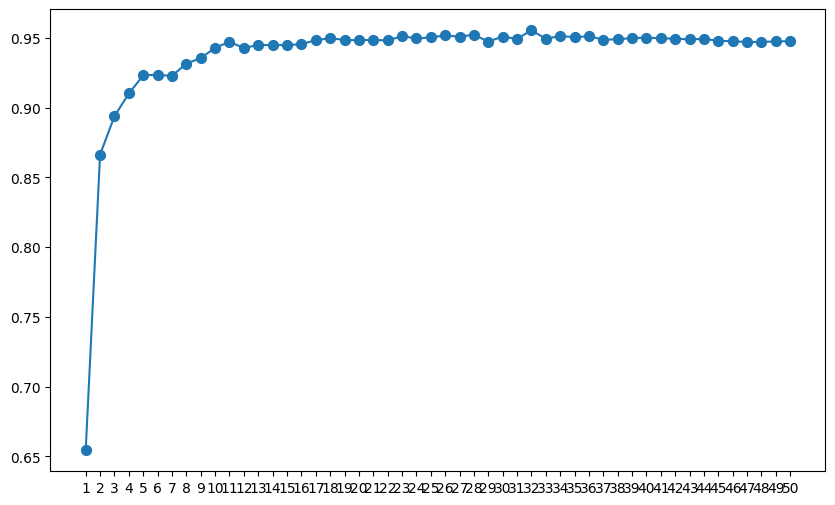

In [14]:
# Placeholders for similarity scores
k_values = []
similarity_scores = []

# Loop through tuples within list of nmf models
for (k, topic_weights, token_weights) in topic_models:
    
    # For each model, retrieve top tokens (with highest loadings on weight)
    token_rankings = []
    for topic_index in range(k):
        token_rankings.append(get_top_tokens(list_tokens, token_weights, topic_index, 5)[0])

        # top_tokens, _ = get_top_tokens(list_tokens, token_weights, topic_index, 5)
        # print(f"Topic {topic_index+1}: {top_tokens}")
        
    # Measure similarity using skip-gram model
    k_values.append(k)
    similarity_scores.append(topic_similarity(sg_model, token_rankings))

# Plot mean intra-topic token similarity scores
fig = plt.figure(figsize=(10,6))
plt.scatter(k_values, similarity_scores, s=50)
ax = plt.plot(k_values, similarity_scores)
plt.xticks(k_values);

Topic 01: principle, paradigm, personality_ethic, child, character, golden_egg, experience, goose, deposit, problem
Topic 02: scan_downloadscan, radical_candor, team_member, team, answer, feedback, question, leader, manager, guidance
Topic 03: coachee, coach, conversation, goal, option, coaching, question, reality, model, grow_model
Topic 04: feedback, sbi_feedback, sbi_model, behavior, center_creative, situation_behavior, negative_feedback, model, negative_process, m_sd
Topic 05: win_win, win_lose, agreement, lose_win, deal, cooperate, paradigm, don_t, criterion, performance_agreement
Topic 06: habit_highly, habit, effective_people, book, stephen_covey, covey, franklincovey, principle, leadership, live
Topic 07: quadrant_ii, habit, quadrant, schedule, generation, activity, item, urgent, priority, role
Topic 08: synergy, empathic_listening, seek_understand, open, listen, don_t, problem, communication, synergistic, habit
Topic 09: grow_model, client, session, action, coach, coaching_ses

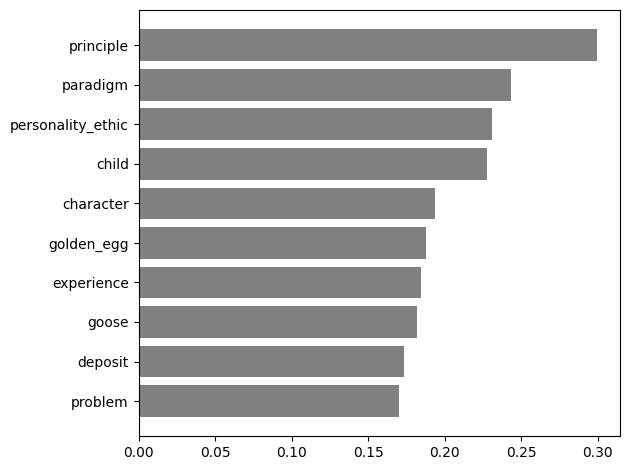

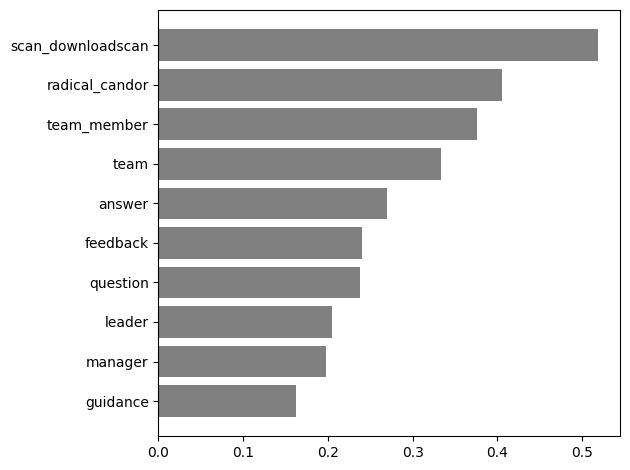

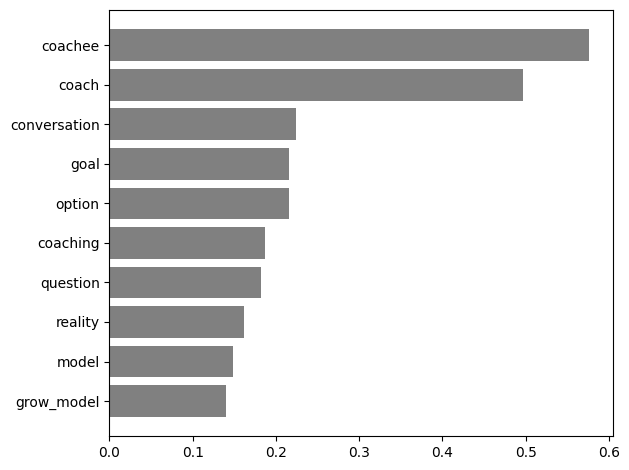

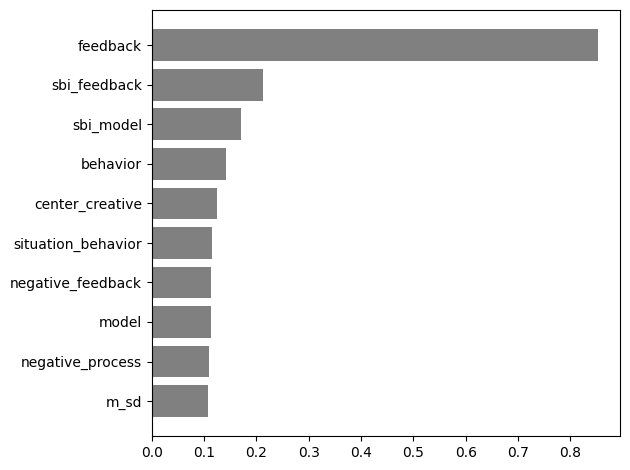

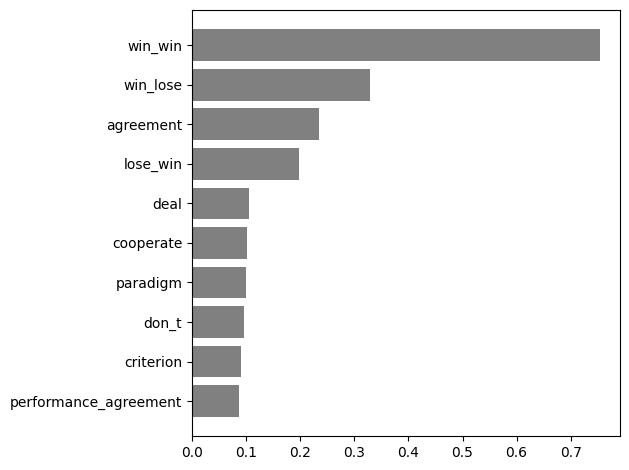

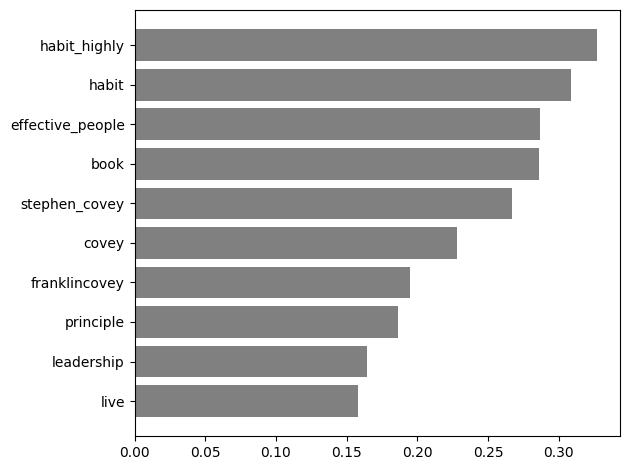

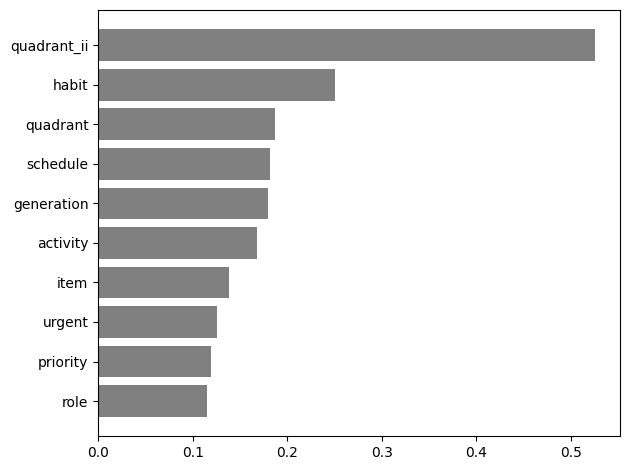

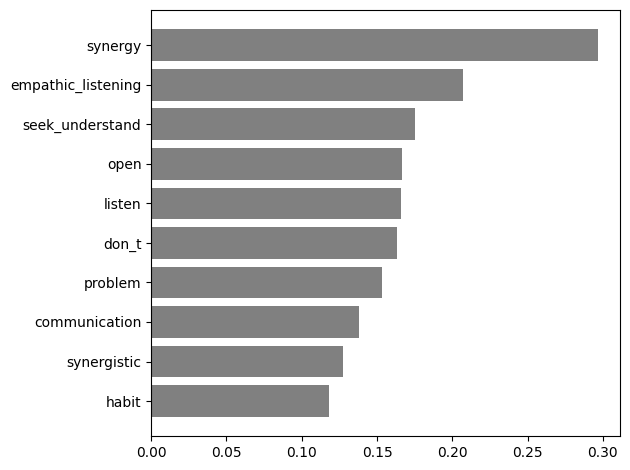

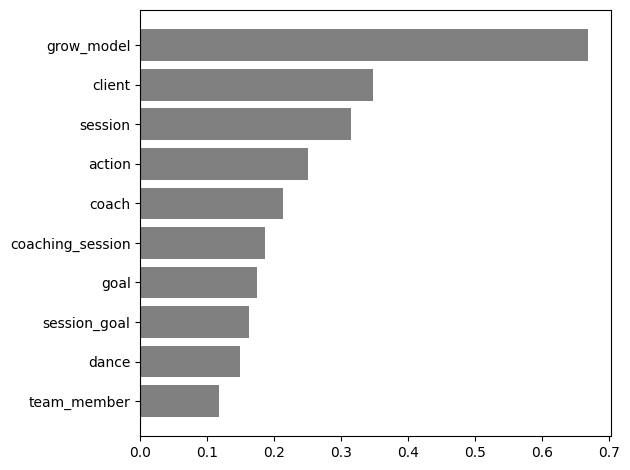

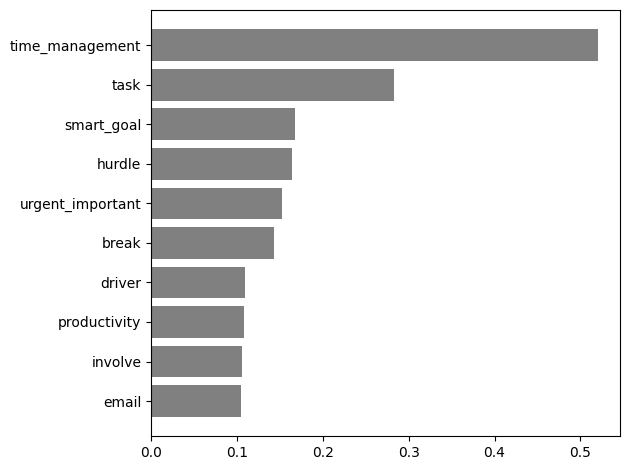

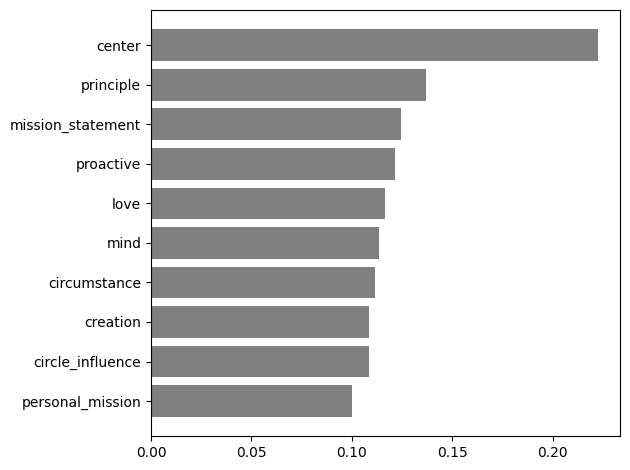

In [17]:
# #### Fit & Evaluate Final Topic Model

# Retrain model for specified k
k = 11
nmf_model = decomposition.NMF(init='nndsvd', n_components=k, max_iter=500)

# Capture topic and token weighting matrices
topic_weights = nmf_model.fit_transform(tfidf_dtm)
token_weights = nmf_model.components_

# Obtain top-n token for each topic
top_tokens = []
for topic_index in range(k):
    top_tokens.append(get_top_tokens(list_tokens, token_weights, topic_index, 10))#10
    top_tokens_str = ", ".join(top_tokens[topic_index][0])
    print("Topic %02d: %s" % (topic_index+1, top_tokens_str))


# Function to plot top topic-tokens
def plot_top_tokens(top_tokens, top_weights):   
    # sort tokens
    top_tokens.reverse()
    top_weights.reverse()
    
    # print bar chart
    ypos = np.arange(len(top_tokens))
    ax = plt.barh(ypos, top_weights, color='grey', tick_label=top_tokens)
    plt.tight_layout()
    plt.show()


# Plot top 10 tokens for each topic
for topic_index in range(k):
    top_tokens, top_weights = get_top_tokens(list_tokens, token_weights, topic_index, 10)
    plot_top_tokens(top_tokens, top_weights)


# Function to identify representative documents for specified topic
def get_doc_examples(all_docs, topic_weights, topic_number, top_n):
    # sort by weighting
    top_indices = np.argsort(topic_weights[:,topic_number])[::-1]
    
    # identify documents for top-ranked indices
    top_examples = []
    for doc_index in top_indices[0:top_n]:
        top_examples.append(all_docs[doc_index])
    return top_examples


# # Print top n documents for a sepecified topic
# topic_examples = get_doc_examples(df['comment'].tolist(), topic_weights, topic_number=1, top_n=5)
# for i, document in enumerate(topic_examples):
#     print('-- EXAMPLE '+str(i+1)+' '+'--'*50)
#     print(document)